In [1]:
import torch
from torch.utils import data
import random
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import  datasets, transforms, models
from torch.optim import lr_scheduler

In [2]:
device_to = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# Create master dataset and split it into the train, test and valid
def build_dataloaders(batch_size):
    data_train = 'data/train'
    data_valid = 'data/valid'
    
    data_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.RandomRotation(20),
                                          transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.90, 1.11)),
                                           transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

    validation_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    # TODO: Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(data_train, transform=data_transforms)
    test_data = datasets.ImageFolder(data_valid, transform=validation_transforms)
    
#     n = len(master_dataset)  # how many total elements you have
#     n_test = int( n * .1 )  # number of test/val elements (.1 == 10%)
#     n_train = n - 2 * n_test
#     idx = list(range(n))  # indices to all elements
#     train_idx = idx[:n_train]
#     val_idx = idx[n_train:(n_train + n_test)]
#     test_idx = idx[(n_train + n_test):]

#     train_data = data.Subset(master_dataset, train_idx)
#     valid_data = data.Subset(master_dataset, val_idx)
#     test_data = data.Subset(master_dataset, test_idx)
    
    train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    test = torch.utils.data.DataLoader(test_data, batch_size)
    class_names = train_data.classes
    return train, test, class_names


In [44]:
global_batch_size = 30
train_loader, test_loader, class_names = build_dataloaders(global_batch_size)
print(class_names)

['autumn', 'beach', 'christmas', 'easter', 'fashion', 'friends', 'happy', 'landscape', 'love', 'mountains', 'nature', 'snow', 'summer', 'sunset']


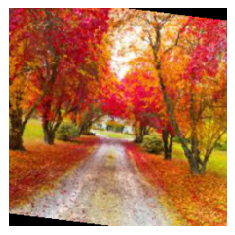

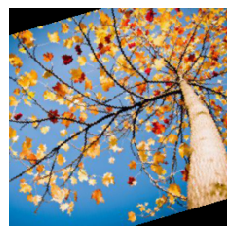

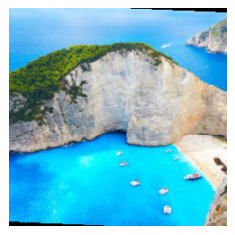

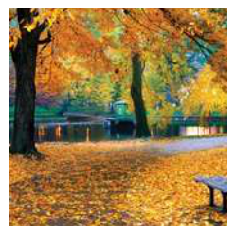

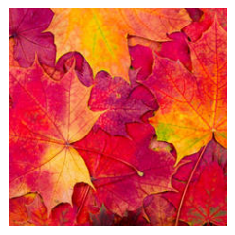

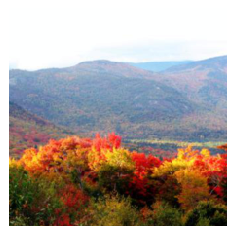

In [40]:
# IEJG - I will test the dataloaders before starting the training.
### Define a function to view the images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def test_image_loaders():
    images, label = next(iter(train_loader))
    imshow(images[0,:])
    imshow(images[1,:])
    imshow(images[2,:])
    
    images, label = next(iter(test_loader))
    imshow(images[0,:])
    imshow(images[1,:])
    imshow(images[2,:])
    
test_image_loaders()

In [6]:
def load_base_model(device, classes):
    model = models.resnet152(pretrained=True)
    # Use GPU if it's available
    

    ## Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.layer3.parameters():
        param.requires_grad = False
        
    for param in model.layer4.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    fc = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 1024)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, len(classes))),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.fc = fc
    model.to(device)
    return model

In [7]:
len(train_loader)

24

In [8]:
def train(inputs, labels, device, model, optimizer, criterion, running_loss):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    return running_loss

In [9]:
def validate(loader, device, model, criterion):
    model.eval()
    test_loss = 0.0
    accuracy = 0.0
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            valid_loss += batch_loss.item()*inputs.size(0)

    valid_loss = valid_loss/len(loader.dataset)
    return test_loss, accuracy, valid_loss
    

In [32]:
def accuracy_calc(loader, model,epochs, epoch, running_loss, test_loss, accuracy, valid_loss, valid_loss_min, max_accu):
    steps = len(loader)
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Step: {steps}.. "
          f"Train loss: {running_loss/steps:.3f}.. "
          f"Test loss: {test_loss/len(loader):.3f}.. "
          f"Test accuracy: {accuracy/len(loader):.3f}.. "
          f"Valid Loss: {valid_loss:.3f}")

    #saving max accuracy
    calc_accu = accuracy/len(loader)
    print(f'lets see {calc_accu} / {max_accu}')
    if max_accu < calc_accu:
        print(f"++++++ Accuracy increase {max_accu:.3f} to {calc_accu}   ===== Saving model =====")
        torch.save(model.state_dict(), 'model_resnet_maxaccu_152_p99.pt')
        max_accu = calc_accu

    # saving max valid_loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_resnet152_p99.pt')
        valid_loss_min = valid_loss
    return valid_loss_min, max_accu

In [34]:
def trainer_loop(train_loader, test_loader, model, epochs, lr, device, max_accu = 0.0):
    optimizer = optim.Adam([
                        {'params': model.layer3.parameters()},
                        {'params': model.layer4.parameters()},
                       {'params': model.fc.parameters()}], lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    criterion = nn.NLLLoss()
    print_every = 5
    valid_loss_min = np.Inf # set initial "min" to infinity
    
    for epoch in range(epochs):
        steps = 0
        running_loss = 0
        for inputs, labels in train_loader:
            steps += 1
            running_loss = train(inputs, labels, device, model, optimizer, criterion, running_loss)
            print(f"Epoch {epoch+1}/{epochs}.. "
              f"Step: {steps}/{len(train_loader)}.. "
              f"Train loss: {running_loss/steps:.3f}.. ")
        test_loss, accuracy, valid_loss = validate(test_loader, device, model, criterion)
        valid_loss_min, max_accu = accuracy_calc(test_loader, model, epochs, epoch, running_loss, test_loss, accuracy, valid_loss, valid_loss_min, max_accu)
        print(test_loss, accuracy, valid_loss, max_accu)
        scheduler.step(valid_loss)
    return model

In [45]:
#final_model = trainer_loop(train_loader, test_loader,load_base_model(device_to, class_names),epochs=15,lr =0.0001,device=device_to )
final_model = trainer_loop(train_loader, test_loader,final_model,epochs=30,lr =0.00001,device=device_to, max_accu = 0.80 )

Epoch 1/30.. Step: 1/39.. Train loss: 0.876.. 
Epoch 1/30.. Step: 2/39.. Train loss: 0.890.. 
Epoch 1/30.. Step: 3/39.. Train loss: 0.795.. 
Epoch 1/30.. Step: 4/39.. Train loss: 0.742.. 
Epoch 1/30.. Step: 5/39.. Train loss: 0.700.. 
Epoch 1/30.. Step: 6/39.. Train loss: 0.716.. 
Epoch 1/30.. Step: 7/39.. Train loss: 0.705.. 
Epoch 1/30.. Step: 8/39.. Train loss: 0.686.. 
Epoch 1/30.. Step: 9/39.. Train loss: 0.694.. 
Epoch 1/30.. Step: 10/39.. Train loss: 0.689.. 
Epoch 1/30.. Step: 11/39.. Train loss: 0.718.. 
Epoch 1/30.. Step: 12/39.. Train loss: 0.737.. 
Epoch 1/30.. Step: 13/39.. Train loss: 0.743.. 
Epoch 1/30.. Step: 14/39.. Train loss: 0.722.. 
Epoch 1/30.. Step: 15/39.. Train loss: 0.711.. 
Epoch 1/30.. Step: 16/39.. Train loss: 0.711.. 
Epoch 1/30.. Step: 17/39.. Train loss: 0.715.. 
Epoch 1/30.. Step: 18/39.. Train loss: 0.701.. 
Epoch 1/30.. Step: 19/39.. Train loss: 0.690.. 
Epoch 1/30.. Step: 20/39.. Train loss: 0.687.. 
Epoch 1/30.. Step: 21/39.. Train loss: 0.678.. 
E

KeyboardInterrupt: 

1020


'_DataLoader__initialized, __class__, __delattr__, __dict__, __dir__, __doc__, __eq__, __format__, __ge__, __getattribute__, __gt__, __hash__, __init__, __init_subclass__, __iter__, __le__, __len__, __lt__, __module__, __ne__, __new__, __reduce__, __reduce_ex__, __repr__, __setattr__, __sizeof__, __str__, __subclasshook__, __weakref__, batch_sampler, batch_size, collate_fn, dataset, drop_last, num_workers, pin_memory, sampler, timeout, worker_init_fn'

In [13]:
def load_checkpoint(device, classes):
    model = load_base_model(device_to, classes)
    model.load_state_dict(torch.load('model_resnet_maxaccu_152_p99.pt', map_location=lambda storage, loc: storage))
    return model

In [17]:
def model_class_validation(loader, model, device, criterion, classes):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    batch_size = 50
    model.eval() # prep model for evaluation
    with torch.no_grad():
        for data, target in loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            data, target = data.to(device), target.to(device)
            print(device, data.size(), target.size())
            output = model.forward(data)
            # calculate the loss
            loss = criterion(output, target)
            # update test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(target.size(0)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # calculate and print avg test loss
        test_loss = test_loss/len(loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

        for i in range(len(class_total)):
            if class_total[i] > 0:
                 print('Test Accuracy of %5s %5s: %2d%% (%2d/%2d)' % (
                  classes[i],str(i+1) ,100.0 * class_correct[i] / class_total[i],
                  np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
              print('Test Accuracy of %5s: N/A (no training examples)' % (i))

        print('\nTest Accuracy (Overall): %.6f%% (%2d/%2d)' % (
          100. * np.sum(class_correct) / np.sum(class_total),
          np.sum(class_correct), np.sum(class_total)))

In [47]:
model_class_validation(test_loader, load_checkpoint(device_to, class_names), device_to, nn.NLLLoss(), class_names )

cuda torch.Size([30, 3, 224, 224]) torch.Size([30])
cuda torch.Size([30, 3, 224, 224]) torch.Size([30])
cuda torch.Size([30, 3, 224, 224]) torch.Size([30])
cuda torch.Size([30, 3, 224, 224]) torch.Size([30])
cuda torch.Size([5, 3, 224, 224]) torch.Size([5])
Test Loss: 0.494282

Test Accuracy of autumn     1: 100% (10/10)
Test Accuracy of beach     2: 100% ( 8/ 8)
Test Accuracy of christmas     3: 100% (10/10)
Test Accuracy of easter     4: 88% ( 8/ 9)
Test Accuracy of fashion     5: 100% (10/10)
Test Accuracy of friends     6: 100% (10/10)
Test Accuracy of happy     7: 88% ( 8/ 9)
Test Accuracy of landscape     8: 50% ( 4/ 8)
Test Accuracy of  love     9: 100% ( 8/ 8)
Test Accuracy of mountains    10: 100% (10/10)
Test Accuracy of nature    11: 50% ( 5/10)
Test Accuracy of  snow    12: 80% ( 8/10)
Test Accuracy of summer    13: 25% ( 2/ 8)
Test Accuracy of sunset    14: 100% ( 5/ 5)

Test Accuracy (Overall): 84.800000% (106/125)
